# RBF kernel

## 一、数学表达式与一些简单的性质
RBF kennel 又被称为高斯kernel，其数学表达式为:

$$k(x,z)=\exp(-\frac{\begin{Vmatrix}x-z \end{Vmatrix} ^2}{2\sigma^2})$$

通过数学表达式我们可以发现，任何一个原空间中的数据点被映射到特征空间之中，其到特征空间原点的距离的平方为：

$$norm^2=\phi(x)^T\phi(x)=k(x,x)=\exp(-\frac{\begin{Vmatrix}x-x \end{Vmatrix} ^2}{2\sigma^2})=1$$

另外，任意两个数据点在 特征空间中的相似可以用其向量(由特征空间的原点指向数据点)的夹角余弦表示：

$$\cos (\theta)=\frac{\phi(x_1)^T \phi(x_2)}{\begin{Vmatrix}\phi(x_1)\end{Vmatrix}\begin{Vmatrix}\phi(x_2)\end{Vmatrix}}=\phi(x_1)^T \phi(x_2)=k(x_1,x_2)$$

所以任意两点之间的余弦就等于kernel 函数的数值


所以RBF kernel的性质非常得优雅：

> 在特征空间中，每一个数据点的norm都为1且为正
> 所以每一个数据点都被映射到特征空间的超球面的表面上
> 任意两点之间的相似程度由向量的余弦表示，也就是两点的kernel 函数值表示


如下图所示:
<img src='image1.png'>




## 二、数据点相似程度的直观解释

1. 如果两个数据点的余弦距离接近1，那么这两个点在特征空间中非常相似
2. 如果这两个数据点的余弦距离越接近0，那么这两个点在特征空间中越不相似


<img src='image2.png'>


我们使用kernel的目的就是要使得原来非线性可分的点在特征空间中可分，那么我们使用RBFkernel的目的也是尽量使得数据点在特征空间中更容易线性可分。

因此我们的目标是使得相同类别的点的向量方向尽可能相同，即余弦接近1，而不同类别的点尽量方向接近九十度，余弦接近0.

<img src='image3.png'>

那么对于RBF kernel来说，只有一个参数 $\sigma$ 控制着这些数据点在特征空间中相似程度。

$$k(x,z)=\exp(-\frac{\begin{Vmatrix}x-z \end{Vmatrix} ^2}{2\sigma^2})$$

* 当$\sigma$ 非常小的时候，k(x,z)=0,任意两点之间角度为90度，不相似


* 当$\sigma$ 非常大的时候，k(x,z)=1,任意两点之间角度为0度，向量重合在一起，非常相似



那么随着 $\sigma$ 从小到大变化的时候，原来更相近的两个点向量夹角减小地越快，而原来不相近的点向量夹角减少地越慢，因此当$\sigma$取某个值的时候，同一个类别的点和不同类别的点被分开，并且效果最好

我们用$w(\sigma)$表示同一类别中的数据点之间的余弦值的平均
<img src='image4.png'>

我们用$b(\sigma)$表示不同类别中的数据点之间的余弦值的平均

<img src='image5.png'>

我们的目标是要找到一个$\sigma$，使得

$$w(\sigma) \rightarrow 1^- \\
b(\sigma) \rightarrow 0^+
$$

也就是说要要到一个$\sigma$，使得：

$$1-w(\sigma) \rightarrow 0^+ \\
b(\sigma) \rightarrow 0^+
$$

因此决策函数被定义为：

$$J(\sigma)=(1-w(\sigma))+b(\sigma)=1-w(\sigma)+b(\sigma)$$

<img src='image6.png'>

## Python 实现

我们的目标是求出$w(\sigma) \text{ and } b(\sigma)$,

我们如果能够从kernel matrix中找到`所有属于同一个类别的点`，将其RBF kernel 函数值相加起来就可以得到所有属于同一个类别的kernel值

再将整个kernel matrix中的值相加减掉刚才属于同一个类别的kernel 值，就是属于不同类别的kernel值之和

再将两者除以各自的数量，就可以得到平均值

假设有三个不同的类别，如下图所示：

<img src='image7.jpg'>

上图只是为了表示方便，我们计算矩阵K的时候不用按照类别的顺序

把上图中的阴影部分加起来除以相应的个数就是w，
把整个矩阵减掉阴影部分加起来再除以相应的个数就是b



In [2]:
%matplotlib inline

from sklearn.svm import SVC
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets

# 获得训练数据
iris = datasets.load_iris()

X=iris.data
t=iris.target

In [19]:
from scipy.linalg import norm
from sklearn.metrics.pairwise import rbf_kernel

SIGMA=0.5
def cal_J(gamma):
    
    X=iris.data
    t=iris.target
    K=rbf_kernel(X,gamma=gamma)
    numberOfClass=len(np.unique(t))

    #计算同类别的kernel 值得总和
    sameClassSum=0

    #为了计算w我们需要统计每一个类别的数据点的个数
    numberOfClassSample=[]
    block1=K[0:51,0:51]
    for label in np.unique(t):
        IndexOfThisLabel=t==label
        sameClassSum+=np.sum(K[np.ix_(IndexOfThisLabel,IndexOfThisLabel)])
        numberOfClassSample.append(np.sum(IndexOfThisLabel))

    #print numberOfClassSample
    diffClassSum=np.sum(K)-sameClassSum

    w=sameClassSum/np.sum(np.square(numberOfClassSample))

    b=diffClassSum/(np.square(np.sum(numberOfClassSample))-np.sum(np.square(numberOfClassSample)))

    J=1-w+b
    return J




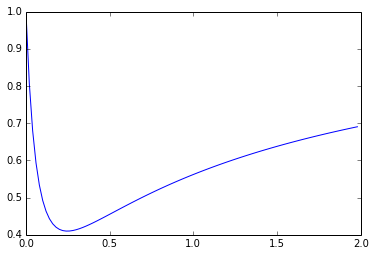

In [24]:
sigmaValue=np.arange(0,2,0.02)
J=np.zeros_like(sigmaValue)
for i in xrange(len(sigmaValue)):
    J[i]=cal_J(sigmaValue[i])
plt.plot(sigmaValue,J)

In [25]:
from scipy.optimize import minimize

minimize(cal_J,0.2)

   status: 0
  success: True
     njev: 6
     nfev: 18
 hess_inv: array([[ 0.30520045]])
      fun: 0.40991833280965956
        x: array([ 0.24713584])
  message: 'Optimization terminated successfully.'
      jac: array([  4.19095159e-06])

结合图示和scipy的最优化函数可以看出来，当gamma等于0.24713584的时候，J最小，为0.40991833280965956